### Variational autoencoder (VAE)

Variational autoencoder is a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "**Generative Model**".

* An encoder network turns the input samples x into two parameters in a latent space, which we will note **z_mean** and **z_log_sigma**. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via **z = z_mean + exp(z_log_sigma) * epsilon**, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

* The parameters of the model are trained via **two loss functions**: a reconstruction loss forcing the decoded samples to match the initial inputs and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

(KL divergence is a non-symmetric metric that measures the **relative entropy** or difference in information represented by two distributions. It can be thought of as measuring the distance between two data distributions showing how different the two distributions are from each other.)

In [1]:
import keras
import numpy as np
from keras import layers
from keras import regularizers
from keras.datasets import mnist
import matplotlib.pyplot as plt

First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [2]:
original_dim = 28 * 28  # IMG_SIZE
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [3]:
from keras import backend as K

def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)  # Random normal tensor
  return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Map these sampled latent points back to reconstructed inputs

In [4]:
import keras

# Create Encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create Decoder
latent_inputs = keras.Input(shape=(latent_dim, ), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# Instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

* An end-to-end autoencoder mapping inputs to reconstructions
* An encoder mapping inputs to the latent space
* A generator that can take points on the latent space and will output the corresponding reconstructed samples.

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [5]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim   # to scale the loss appropriately, as the binary cross-entropy is calculated on a per-pixel basis.

'''
Binary cross-entropy between the true probabilities and predicted probabilities is 0.5 for each pixel. 
Without the multiplication by original_dim, the total reconstruction loss would be 1.0 (0.5 for each pixel), which would be misleading 
as it does not take into account the fact that the image has only 2 pixels. Multiplying the reconstruction loss by original_dim ensures 
that the loss is scaled appropriately for images of different sizes, and allows for a fair comparison of models trained on different datasets.

Without multiplication by original_dim:

reconstruction_loss = binary_crossentropy(pixel_1_true_probs, pixel_1_predicted_probs) +
                      binary_crossentropy(pixel_2_true_probs, pixel_2_predicted_probs) + 
                      ... +
                      binary_crossentropy(pixel_784_true_probs, pixel_784_predicted_probs)
                     = 0.1 + 0.1 + ... + 0.1  (784 times)
                     = 78.4

In this case, the reconstruction loss is the sum of the losses for each pixel, 
which gives a value of 78.4. However, this value does not take into account the size of the image.

By multiplying the reconstruction loss by original_dim, we can scale the loss to represent the total loss for the entire image:
reconstruction_loss = 78.4 * 784 = 61475.2
'''

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')  # We will train VAE on MNIST dataset

In [6]:
# Get MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 2s 0us/step


In [7]:
vae.fit(x_train, x_train, epochs=100, batch_size=32, validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 19s 5ms/step - loss: 187.1694 - val_loss: 169.2437
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 166.5175 - val_loss: 163.9745
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 162.6289 - val_loss: 161.2478
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 160.2746 - val_loss: 159.3713
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 158.7224 - val_loss: 158.2695
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 157.5779 - val_loss: 157.2267
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 156.5926 - val_loss: 156.3676
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 155.6612 - val_loss: 155.3405
Epoch 9/100
1875/1875 [==============================] - 7s 4ms/step - loss: 154.7930 - val_loss: 154.5222
Epoch 10/100
1875/1875 [============

313/313 [==============================] - 2s 5ms/step


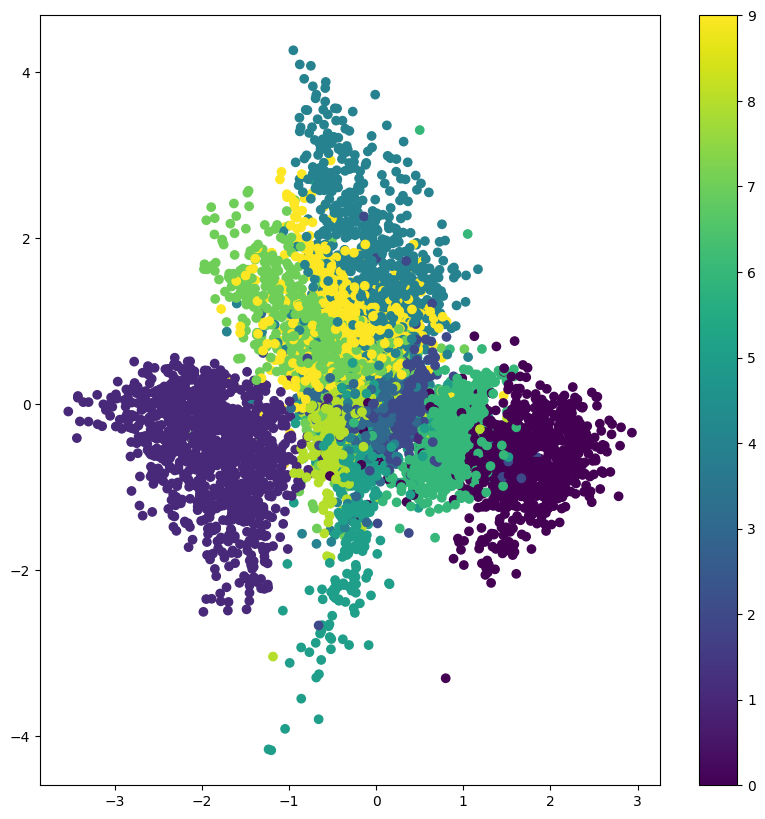

In [14]:
x_test_encoded_mean, _, _ = encoder.predict(x_test, batch_size=32)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded_mean[:, 0], x_test_encoded_mean[:, 1], c=y_test)
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 29ms/step


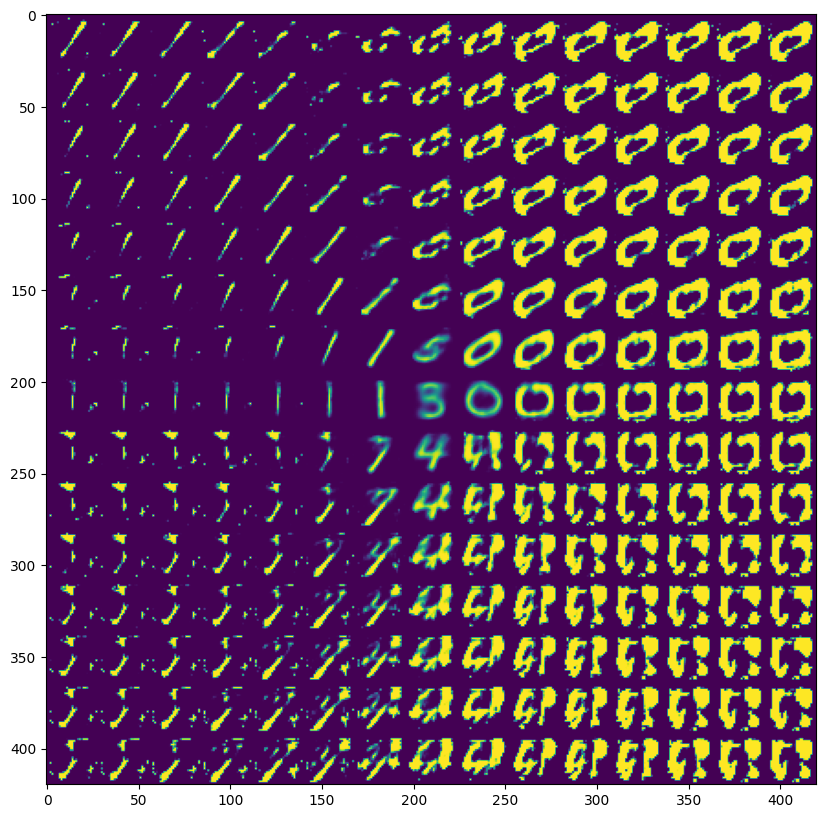

In [15]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Reference

https://blog.keras.io/building-autoencoders-in-keras.html